In [149]:
# Import CVX and numpy libraries
import cvxpy as cvx
import numpy as np
import random
import copy
import math
import time
import networkx as nx
import matplotlib.pyplot as plt

## Question 2: SNL with Noise Data

We use the same code as we did in Question 1 to generate the SNL problems

In [150]:
def generate(n,npoints):
    # Set the limits
    origA = np.full((n+1,n),-5.)
    rangA = np.full((n+1,n), 10.)
    origP = np.full((npoints,n),-5.)
    rangP = np.full((npoints,n), 10.)

    # Construct the anchor points
    a = np.random.rand(n+1,n)
    a = origA + np.multiply(a,rangA)

    # Construct the sensor points
    p = np.random.rand(npoints,n)
    p = origP + np.multiply(p,rangP)

    adjacency = np.full((npoints+n+1,npoints+n+1),-1.)

    if(n > 1):
        minConstr = 3
        maxConstr = 4
        minPointConstr = 2
        minAnchConstr = 2
    else:
        minConstr = 2
        maxConstr = 3
        minPointConstr = 1
        minAnchConstr = 1

    anchList = [i for i in range(n+1)]
    pointList = [i for i in range(npoints)]
    off = n + 1

    for i in range(npoints):
        random.shuffle(anchList)
        random.shuffle(pointList)
        # Set anchor constraints, between 1 and 3
        numAnch = random.randint(minAnchConstr,minConstr)
        for l in range(numAnch):
            adjacency[anchList[l],i+off] = np.linalg.norm(a[anchList[l]] - p[i])
            adjacency[i+off,anchList[l]] = adjacency[anchList[l],i+off]
        #print(numAnch)
        # Count number of constraints already set for this point
        countConstr = 0
        for l in range(npoints+off):
            if(adjacency[l,i+off] > 0):
                countConstr = countConstr + 1
        # Set point constraints, between 0 and 3
        if(minConstr - countConstr >= 0):
            numPoint = random.randint(minConstr-countConstr,3)
            count = numPoint
            l = 0
            while(count > 0 and l < len(pointList)):
                if(pointList[l] != i):
                    countConstr = 0
                    for k in range(npoints+off):
                        if(adjacency[k,pointList[l]+off] > 0):
                            countConstr = countConstr + 1
                    if(countConstr < maxConstr):
                        adjacency[pointList[l]+off,i+off] = \
                            np.linalg.norm(p[pointList[l]] - p[i])
                        adjacency[i+off,pointList[l]+off] = \
                            adjacency[pointList[l]+off,i+off]
                        count = count - 1
                l = l + 1
    return [a, p, adjacency]

In [151]:
def generate_inside_hull(n,npoints):
    # Set the limits
    origA = np.full((n+1,n),-5.)
    rangA = np.full((n+1,n), 10.)
    origP = np.full((npoints,n),-5.)
    rangP = np.full((npoints,n), 10.)
    
    if(n == 1):
        a = np.array([-6., 6.])
    elif(n == 2):
        a = np.array([[-6., 15.], [-6., -15.], [8., 0.]])
    elif(n == 3):
        a = np.array([[-6., 15.,-10.], [-6., -15.,-10.], \
                      [8., 0., -10.], [0., 0., 10.]])
    # Construct the sensor points
    p = np.random.rand(npoints,n)
    p = origP + np.multiply(p,rangP)

    adjacency = np.full((npoints+n+1,npoints+n+1),-1.)

    if(n > 1):
        minConstr = 3
        maxConstr = 4
        minPointConstr = 2
        minAnchConstr = 2
    else:
        minConstr = 2
        maxConstr = 3
        minPointConstr = 1
        minAnchConstr = 1

    anchList = [i for i in range(n+1)]
    pointList = [i for i in range(npoints)]
    off = n + 1

    for i in range(npoints):
        random.shuffle(anchList)
        random.shuffle(pointList)
        # Set anchor constraints, between 1 and 3
        numAnch = random.randint(minAnchConstr,minConstr)
        for l in range(numAnch):
            adjacency[anchList[l],i+off] = np.linalg.norm(a[anchList[l]] - p[i])
            adjacency[i+off,anchList[l]] = adjacency[anchList[l],i+off]
        #print(numAnch)
        # Count number of constraints already set for this point
        countConstr = 0
        for l in range(npoints+off):
            if(adjacency[l,i+off] > 0):
                countConstr = countConstr + 1
        # Set point constraints, between 0 and 3
        if(minConstr - countConstr >= 0):
            numPoint = random.randint(minConstr-countConstr,3)
            count = numPoint
            l = 0
            while(count > 0 and l < len(pointList)):
                if(pointList[l] != i):
                    countConstr = 0
                    for k in range(npoints+off):
                        if(adjacency[k,pointList[l]+off] > 0):
                            countConstr = countConstr + 1
                    if(countConstr < maxConstr):
                        adjacency[pointList[l]+off,i+off] = \
                            np.linalg.norm(p[pointList[l]] - p[i])
                        adjacency[i+off,pointList[l]+off] = \
                            adjacency[pointList[l]+off,i+off]
                        count = count - 1
                l = l + 1
    return [a, p, adjacency]

In [152]:
#The objective function for steepest descent
def SNL(a, x, d):
    sum_obj = 0
    
    for (distance, i, j, truth) in d:
        if truth:
            sum_obj += ((np.linalg.norm(a[j] - x[i]) ** 2) - \
                        distance ** 2) ** 2
        else:
            sum_obj += (((np.linalg.norm(x[i] - x[j]) ** 2) - \
                         distance ** 2) ** 2)/2
    
    return sum_obj

# Here, we perform the gradient of the objective function
def dSNL(a, x, d, npoints, n):
    sum_x = np.zeros((npoints, n))
    
    for (distance, i, j, truth) in d:
        if truth:
            sum_x[i] += 4 * (np.linalg.norm(a[j] - x[i]) ** 2 - \
                             distance ** 2) * (-a[j] + x[i])
        else:
            sum_x[i] += 4 * (np.linalg.norm(x[i] - x[j]) ** 2 - \
                             distance ** 2) * (x[i] - x[j])

    return sum_x

# Updated steepest descent where we perform it twice for the two
# different sensors
def steepest_descent_2(op, dop, a, xin, d, niter, npoints, n):
    x = np.copy(xin)
    
    for i in range(0, niter):
            direction = dop(a, x, d, npoints, n)
            
            alpha = 1.
            
            for j in range(npoints):
                while(op(a, x  - alpha * direction, d) > op(a, x, d) \
                      - 0.5 * alpha * np.dot(direction[j], direction[j])):
                        if alpha < 1e-9:
                            break
                        alpha *= 0.9

            x -= alpha * direction
    
    return x

## SNL with noise
The following function performs the SNL problem with noise terms added to the SDP problem. We solve the problem  with CVXPY and then, with the resulting solution as the starting condition, run Steepest Descent. 

In [162]:
def SNL_noise(n, npoints, convex, niter, printOut = False, graph = False):
    #Add timing and running totals
    start = time.time()
    totalRMSE = 0
    
    for iteration in range(niter):
        #Generate different types of problems
        if convex:
            (a, p, adjacency) = generate(n, npoints)
        else:
            (a, p, adjacency) = generate_inside_hull(n, npoints)
        # Compute the Euclidian distances to the anchor points
        adjSize = len(p) + len(a)
        asize = len(a)
        d = []
        #Generate the d variable for storing edges and 
        #information from the adjacency matrix
        for i in range(adjSize):
            for j in range(adjSize):
                if(j > i and adjacency[i][j] > 0 and i < asize):
                    d.append((adjacency[i][j], j - asize, i, True))
                elif(j > i and adjacency[i][j] > 0):
                    d.append((adjacency[i][j], i - asize, j - asize, False))

        # Construct the CVX variables to minimize
        x = [cvx.Variable(1) for i in range(len(d) * 2)]
    
        #The size of the our adjacency matrix
        T = n + npoints

        z = cvx.Semidef(T)
        
        #The following constructs the SNL problem with noise
        #constraints
        eyeConstraint = []
        anchorConstraints = []
        pointConstraints = []

        for i in range(n):
            temp = np.zeros((T,T))
            temp[i][i] = 1
            eyeConstraint.append(temp)

        temp = np.zeros((T,T))
        for i in range(n):
            for j in range(n):
                temp[i][j] = 1
        eyeConstraint.append(temp)

        for (distance, i, j, truth) in d:
            if truth:
                temp = np.zeros(npoints)
                temp[i] = -1.
                anchorConstraints.append((np.outer(np.append(a[j], temp), \
                                         np.append(a[j], temp)), distance))
            else:
                tempi = np.zeros(npoints)
                tempj = np.zeros(npoints)
                tempi[i] = 1.
                tempj[j] = 1.
                temp = tempi - tempj
                corner = np.zeros(n)
                temp = np.append(corner, temp)
                pointConstraints.append((np.outer(temp,temp), distance))

        matConstraints = anchorConstraints + pointConstraints

        #Another empty states list
        states = []
        
        #The following is the new objective function
        #and the constraints for our SNL with noise problem
        cost = cvx.norm(sum(x))
        
        constr = []
        
        #Force the constraints as enumerated in the handout
        for i, mat in enumerate(eyeConstraint):
            if i < len(eyeConstraint) - 1:
                constr.append(cvx.sum_entries(cvx.mul_elemwise(mat, z)) == 1)
            else:
                constr.append(cvx.sum_entries(cvx.mul_elemwise(mat, z)) == n)

        for i, mat in enumerate(matConstraints):
            constr.append(cvx.sum_entries(cvx.mul_elemwise(mat[0], z)) + \
                          x[2*i] - x[2*i + 1] ==  mat[1] ** 2)
            constr.append(x[2*i] >> 0)
            constr.append(x[2*i + 1] >> 0)

        constr.append(z >> 0)

        #Add the constraints and cost function
        states.append(cvx.Problem(cvx.Minimize(cost), constr))

        #Solve the SDP relaxation problem
        prob = sum(states)
        prob.solve();    
        
        #This is our solution to the problem which we will
        #use as the initial condition for our steepest
        #descent method
        SDPSolution = z.value.A[0:n, n:n + npoints].transpose()
        
        d2 = copy.copy(d)

        for k in range(len(d)):
            (distance, i, j, truth) = d[k]

            if not truth:
                d2.append((distance, j, i, truth))
        
        #Plot the convergence of the steepest descent method
        graphMSE = []
        iterList = [i for i in range(0, 100, 5)]
        if graph:
            for it in iterList:
                soln = steepest_descent_2(SNL, dSNL, a, SDPSolution, \
                                          d2, it, npoints, n)
                MSE = 0
                for i in range(npoints):
                    if printOut:
                        print("Sensor " + str(i) + " is located at " + \
                              str(soln[i]) + " and the actual value is " + str(p[i]))
                    MSE += np.linalg.norm(np.asarray(soln[i]) - np.asarray(p[i]))
                graphMSE.append(MSE)
            plt.plot(iterList, graphMSE)
            plt.xlabel("Number of Iterations")
            plt.ylabel("RMSE")
            plt.show()
        
        #Solve with steepest descent
        soln = steepest_descent_2(SNL, dSNL, a, SDPSolution, d2, 200, npoints, n)
        RMSE = 0
        for i in range(npoints):
            if printOut:
                print("Sensor " + str(i) + " is located at " + str(soln[i]) + \
                      " and the actual value is " + str(p[i]))
            RMSE += np.linalg.norm(np.asarray(soln[i]) - np.asarray(p[i])) ** 2
        totalRMSE += RMSE
    
    #Compute the total time and RMSE
    end = time.time()
    print "Total Time Elapsed (sec): ", end - start
    print "Average RMSE: ", math.sqrt(totalRMSE / niter)

In [164]:
#Output the points, do not plot, and solve a 
#2D problem with outside the cnovex hull
SNL_noise(2, 10, True, 1, True, False)

Sensor 0 is located at [-1.37389329 -1.80595195] and the actual value is [-1.37362587 -1.80602253]
Sensor 1 is located at [ 3.29302625 -4.43564157] and the actual value is [ 3.29302867 -4.4356413 ]
Sensor 2 is located at [-3.46517552 -1.82496946] and the actual value is [-3.45297077 -1.83430774]
Sensor 3 is located at [-0.96906594 -2.52859709] and the actual value is [-0.96678399 -2.5283522 ]
Sensor 4 is located at [ 4.18562205 -4.7953635 ] and the actual value is [ 4.18594399 -4.79534258]
Sensor 5 is located at [ 2.15555989 -0.6126965 ] and the actual value is [ 2.15555994 -0.61269669]
Sensor 6 is located at [ 4.68702881 -2.87180744] and the actual value is [ 4.67991925 -3.02363667]
Sensor 7 is located at [-1.09000814 -4.04067696] and the actual value is [-1.09000771 -4.04067857]
Sensor 8 is located at [-2.10524961  4.59989885] and the actual value is [-2.10524155  4.59989706]
Sensor 9 is located at [-1.0088816   3.78517764] and the actual value is [-1.00883216  3.78514759]
Total Time

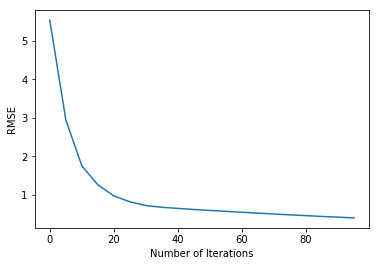

Total Time Elapsed (sec):  48.1317999363
Average RMSE:  0.0841763568702


In [165]:
#OPlot and solve a 2D problem with outside the cnovex hull
SNL_noise(2, 10, True, 1, False, True)

In [166]:
#Performing 2-D SNL with SDP and steepest descent outside the convex hull
SNL_noise(2, 10, True, 10)

Total Time Elapsed (sec):  85.5388059616
Average RMSE:  0.00363678032118
